<a href="https://colab.research.google.com/github/MashaYakus/ML_Lab1/blob/main/ML_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Линейные модели

Попробуем реализовать линейные классификаторы и применить их к набору данных, рассматренному в прошлой работе.

В моем случае, выявление пациентов подверженных инсульту

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import collections
import sklearn
import pickle

In [ ]:
data_base = pd.read_csv('brain_stroke.csv')
print(data_base.shape)
data_base.head()

(4981, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [ ]:
data_base["gender"] = [0 if i == "Male" else 1 for i in data_base["gender"]]
data_base["ever_married"] = [0 if i == "Yes	" else 1 for i in data_base["ever_married"]]
data_base["work_type"] = [0 if i == "Private" else 1 if i == "Self-employed" else 2 for i in data_base["work_type"]]
data_base["Residence_type"] = [0 if i == "Urban" else 1 for i in data_base["Residence_type"]]
data_base["smoking_status"] = [0 if i == "never smoked" else 1 if i == "formerly smoked	" else 2 for i in data_base["smoking_status"]]

In [ ]:
data_base.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,0,0,228.69,36.6,2,1
1,0,80.0,0,1,1,0,1,105.92,32.5,0,1
2,1,49.0,0,0,1,0,0,171.23,34.4,2,1
3,1,79.0,1,0,1,1,1,174.12,24.0,0,1
4,0,81.0,0,0,1,0,0,186.21,29.0,2,1


In [ ]:
data = data_base[:700]

## KNN

In [ ]:
from sklearn.model_selection import train_test_split
x = data.drop(columns='stroke')
y = data['stroke']
x_train, x_test, train_labels, test_labels = train_test_split(x.to_numpy(), y.to_numpy(), test_size = 0.2, random_state = 10)

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k):
        self.k = k
        
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        
    def euclidean_distance(self, row1, row2):
        distance = 0
        for i in range(len(row1)): 
            distance += (row1[i] - row2[i]) ** 2
        return math.sqrt(distance)
        
    def predict(self, maindata):
        res = np.ndarray((maindata.shape[0],))
        for j, data in enumerate(maindata):
            distances = []
            for i, row in enumerate(self.data):
                distances.append((self.euclidean_distance(data, row), self.labels[i]))
            distances.sort(key = lambda tup: tup[0])
            dictionary = collections.defaultdict(int)
            for i in range(self.k):
                dictionary[distances[i][1]] += 1
            res[j] = max(dictionary.items(), key = lambda tup: tup[1])[0]
        return res

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import RocCurveDisplay

knn = Pipeline(steps = [('knn', KNN(4))])
print(knn.get_params())

{'memory': None, 'steps': [('knn', KNN(k=4))], 'verbose': False, 'knn': KNN(k=4), 'knn__k': 4}


In [ ]:
def Print_scores(test_labels, x_test_predict):
    print(f"Accuracy tests: {accuracy_score(test_labels, x_test_predict)}")
    matrix = confusion_matrix(test_labels, x_test_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix = matrix)
    disp.plot()
    plt.show()
    print(f"Precision tests: {precision_score(test_labels, x_test_predict)}")
    print(f"Recall tests: {recall_score(test_labels, x_test_predict)}")
    RocCurveDisplay.from_predictions(test_labels, x_test_predict)
    plt.show()

{'knn__k': 24}
Accuracy train: 0.81125
Accuracy tests: 0.81


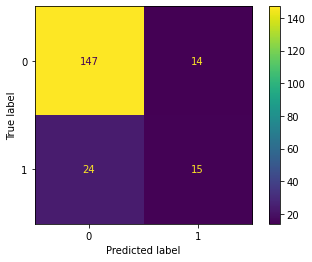

Precision tests: 0.5172413793103449
Recall tests: 0.38461538461538464


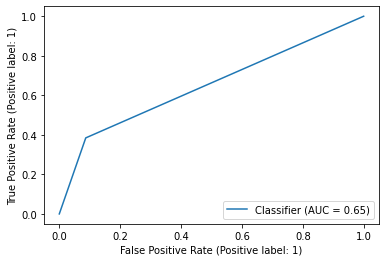

In [ ]:
test = []

for i in range(1, 25):
    test.append(i)

gcv = GridSearchCV(estimator = knn, param_grid={'knn__k': test})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")
x_test_predict = gcv.best_estimator_.predict(x_test)
Print_scores(test_labels, x_test_predict)

{'knn__k': 21}
Accuracy train: 0.8087500000000001
Accuracy tests: 0.795


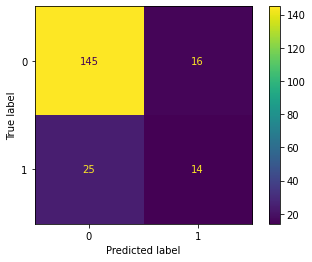

Precision tests: 0.4666666666666667
Recall tests: 0.358974358974359


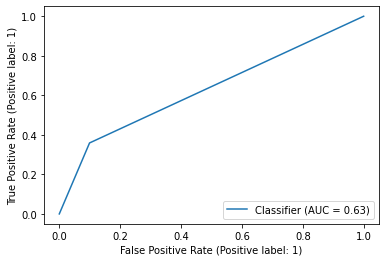

In [ ]:
rcv = RandomizedSearchCV(estimator = knn, param_distributions={'knn__k': test})
rcv.fit(x_train, train_labels)
print(rcv.best_params_)
print(f"Accuracy train: {rcv.best_score_}")
x_test_predict = rcv.best_estimator_.predict(x_test)
Print_scores(test_labels, x_test_predict)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = Pipeline(steps = [('knn', KNeighborsClassifier(4))])
print(knn.get_params())

{'memory': None, 'steps': [('knn', KNeighborsClassifier(n_neighbors=4))], 'verbose': False, 'knn': KNeighborsClassifier(n_neighbors=4), 'knn__algorithm': 'auto', 'knn__leaf_size': 30, 'knn__metric': 'minkowski', 'knn__metric_params': None, 'knn__n_jobs': None, 'knn__n_neighbors': 4, 'knn__p': 2, 'knn__weights': 'uniform'}


{'knn__n_neighbors': 24}
Accuracy train: 0.81125
Accuracy tests: 0.805


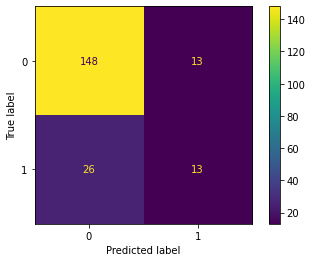

Precision tests: 0.5
Recall tests: 0.3333333333333333


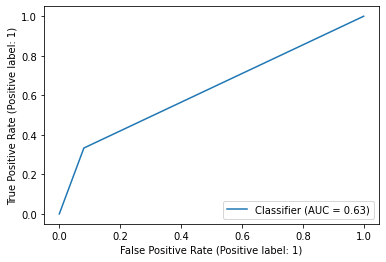

In [ ]:
gcv = GridSearchCV(estimator = knn, param_grid={'knn__n_neighbors': test})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")
x_test_predict = gcv.best_estimator_.predict(x_test)
Print_scores(test_labels, x_test_predict)

# Naive Bayes

In [ ]:
data = data_base

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class NaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self, bins):
        self.bins = bins
        pass
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        self.classes = []
        for j in np.unique(labels):
            
            self.classes.append([])
            for i in range (data.shape[1]):
                self.classes[j].append([*np.histogram(data[labels == j, i], bins = self.bins)])
                self.classes[j][-1][0] = self.classes[j][-1][0].astype('float64') / len(data[labels == j, i])
        
        self.prclasses = np.unique(labels, return_counts = True)[1] / len(labels)
        
    def predict(self, maindata):
        res = np.ndarray((maindata.shape[0],))
        for j, data in enumerate(maindata):
            maximum = 0
            ans = 0
            for i in range(len(self.classes)):
                p = self.prclasses[i]
                for k in range(len(self.classes[i])):
                    ind = np.digitize(data[k], self.classes[i][k][1])
                    
                    if ind >= len(self.classes[i][k][1]) or ind <= 0:
                        p = 0
                    else:
                        p *= self.classes[i][k][0][ind - 1]
                    
                if p > maximum:
                    maximum = p
                    ans = i
            res[j] = ans
        return res  


In [ ]:
bn = Pipeline(steps = [('normalizer', Normalizer()), ('bn', NaiveBayes(10))])
bn.get_params()

{'memory': None,
 'steps': [('normalizer', Normalizer()), ('bn', NaiveBayes(bins=10))],
 'verbose': False,
 'normalizer': Normalizer(),
 'bn': NaiveBayes(bins=10),
 'normalizer__copy': True,
 'normalizer__norm': 'l2',
 'bn__bins': 10}

{'bn__bins': 22}
Accuracy train: 0.8150000000000001
Accuracy tests: 0.76


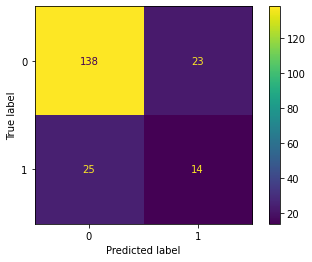

Precision tests: 0.3783783783783784
Recall tests: 0.358974358974359


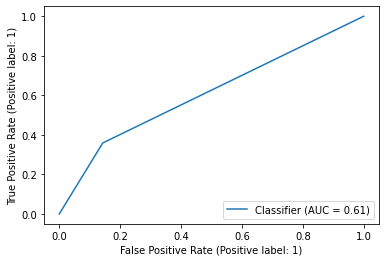

In [ ]:
test = []
for i in range(2, 100):
    test.append(i)

gcv = GridSearchCV(estimator = bn, param_grid={'bn__bins': test})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")
x_test_predict = gcv.best_estimator_.predict(x_test)
Print_scores(test_labels, x_test_predict)

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class GaussianNaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        self.mathexp = []
        self.variance = []
        self.classes = []
        
        for j in np.unique(labels):
            self.classes.append(j)
            self.mathexp.append(data[labels == j,].mean(axis = 0))
            self.variance.append(data[labels == j,].var(axis = 0))
        
    def predict(self, maindata):
        res = np.ndarray((maindata.shape[0],))
        for j, data in enumerate(maindata):
            maximum = 0
            ans = 0
            for i in range(len(self.classes)):
                t = np.exp((-1/2) * ((data - self.mathexp[i]) ** 2) / (2 * self.variance[i])) / np.sqrt(2 * np.pi *  self.variance[i])
                t = np.cumprod(t) 
                if t[-1] > maximum:
                    maximum = t[-1]
                    ans = self.classes[i]
            res[j] = ans
        return res 

Accuracy tests: 0.725


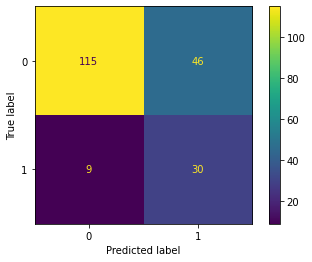

Precision tests: 0.39473684210526316
Recall tests: 0.7692307692307693


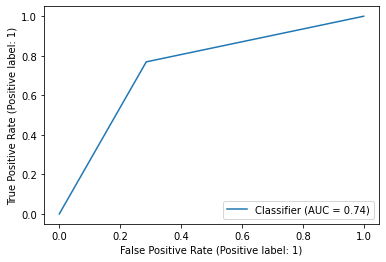

In [ ]:
bn = Pipeline(steps = [('normalizer', Normalizer()), ('bn', GaussianNaiveBayes())])
bn.fit(x_train, train_labels)
x_test_predict = bn.predict(x_test)
Print_scores(test_labels, x_test_predict)

In [ ]:
with open('best_bayes.pickle', 'wb') as f:
    pickle.dump(bn, f, pickle.HIGHEST_PROTOCOL)

Accuracy tests: 0.795


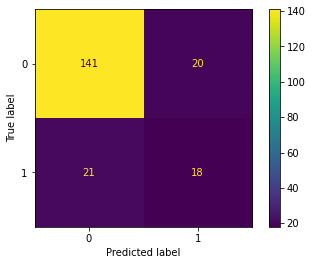

Precision tests: 0.47368421052631576
Recall tests: 0.46153846153846156


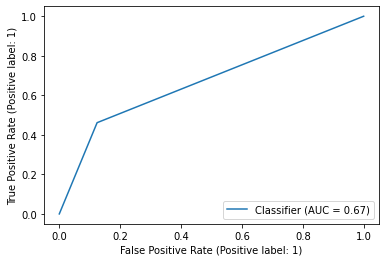

In [ ]:
from sklearn.naive_bayes import GaussianNB

bn = Pipeline(steps = [('normalizer', Normalizer()),('bn', GaussianNB())])
bn.fit(x_train, train_labels)
x_test_predict = bn.predict(x_test)
Print_scores(test_labels, x_test_predict)

## Линейная регрессия

In [ ]:
data = data_base

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class Linear(BaseEstimator, ClassifierMixin):
    def __init__(self, lr, nepoch, batch_size):
        self.lr = lr
        self.nepoch = nepoch
        self.batch_size = batch_size
        pass
    
    def sigmoid(self, x):
        self.l = 1 / (1 + np.exp(-x))
        return self.l
        
    def fit(self, data, labels):
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis = 1)
        self.W = np.random.normal(0, 1, (len(data[0]),))
        
        for i in range(self.nepoch):
            for i in range(0, len(data), self.batch_size):
                xb = data[i:i + self.batch_size]
                yb = labels[i:i + self.batch_size]
                p = np.dot(self.W, xb.T)
                s = self.sigmoid(p)
                dp = np.dot(xb.T, (s - yb).T)
                self.W -= self.lr * dp
        
    def predict(self, maindata):
        maindata = np.concatenate((maindata, np.ones((maindata.shape[0],1))), axis = 1)
        p = np.dot(self.W, maindata.T)
        s = self.sigmoid(p)
        return (s > 0.5).astype('int64')

In [ ]:
import sklearn
from sklearn.preprocessing import Normalizer

lin = Pipeline(steps = [('normalizer', Normalizer()),('lin', Linear(0.1, 10, 5))])
print(lin.get_params())

{'memory': None, 'steps': [('normalizer', Normalizer()), ('lin', Linear(batch_size=5, lr=0.1, nepoch=10))], 'verbose': False, 'normalizer': Normalizer(), 'lin': Linear(batch_size=5, lr=0.1, nepoch=10), 'normalizer__copy': True, 'normalizer__norm': 'l2', 'lin__batch_size': 5, 'lin__lr': 0.1, 'lin__nepoch': 10}


{'lin__batch_size': 1, 'lin__lr': 0.1, 'lin__nepoch': 1}
Accuracy train: 0.21125
Accuracy tests: 0.195


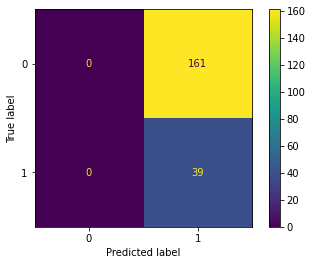

Precision tests: 0.195
Recall tests: 1.0


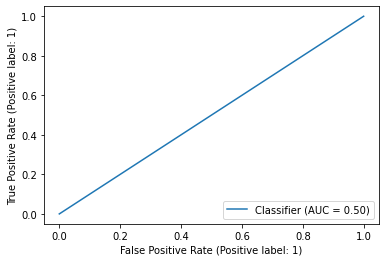

In [ ]:
gcv = GridSearchCV(estimator = lin, param_grid={'lin__nepoch': [1, 5, 10, 20], 'lin__batch_size': [1, 5, 10], 'lin__lr': [0.1, 0.01, 0.001]})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")
x_test_predict = gcv.best_estimator_.predict(x_test)
Print_scores(test_labels, x_test_predict)

{'lin__nepoch': 5, 'lin__lr': 0.1, 'lin__batch_size': 10}
Accuracy train: 0.7178571428571427
Accuracy tests: 0.6857142857142857


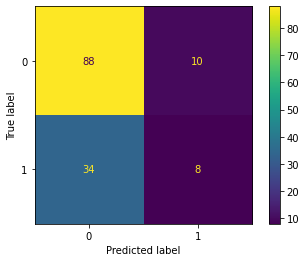

Precision tests: 0.4444444444444444
Recall tests: 0.19047619047619047


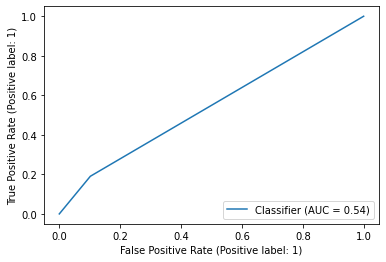

In [ ]:
rcv = RandomizedSearchCV(estimator = lin, param_distributions={'lin__nepoch': [1, 5, 10, 20], 'lin__batch_size': [1, 5, 10], 'lin__lr': [0.1, 0.01, 0.001]})
rcv.fit(x_train, train_labels)
print(rcv.best_params_)
print(f"Accuracy train: {rcv.best_score_}")
x_test_predict = rcv.best_estimator_.predict(x_test)
Print_scores(test_labels, x_test_predict)

In [ ]:
from sklearn.linear_model import SGDClassifier

lin = Pipeline(steps = [('normalizer', Normalizer()),('lin', SGDClassifier(loss = 'log'))])
print(lin.get_params())

{'memory': None, 'steps': [('normalizer', Normalizer()), ('lin', SGDClassifier(loss='log'))], 'verbose': False, 'normalizer': Normalizer(), 'lin': SGDClassifier(loss='log'), 'normalizer__copy': True, 'normalizer__norm': 'l2', 'lin__alpha': 0.0001, 'lin__average': False, 'lin__class_weight': None, 'lin__early_stopping': False, 'lin__epsilon': 0.1, 'lin__eta0': 0.0, 'lin__fit_intercept': True, 'lin__l1_ratio': 0.15, 'lin__learning_rate': 'optimal', 'lin__loss': 'log', 'lin__max_iter': 1000, 'lin__n_iter_no_change': 5, 'lin__n_jobs': None, 'lin__penalty': 'l2', 'lin__power_t': 0.5, 'lin__random_state': None, 'lin__shuffle': True, 'lin__tol': 0.001, 'lin__validation_fraction': 0.1, 'lin__verbose': 0, 'lin__warm_start': False}


{'lin__alpha': 0.001, 'lin__max_iter': 1500}
Accuracy train: 0.7232142857142858
Accuracy tests: 0.7071428571428572


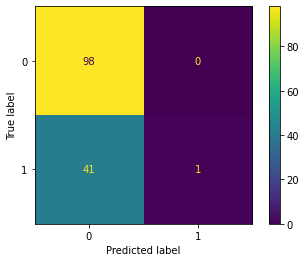

Precision tests: 1.0
Recall tests: 0.023809523809523808


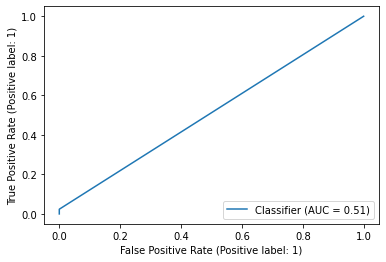

In [ ]:
gcv = GridSearchCV(estimator = lin, param_grid={'lin__max_iter': [100, 1000, 1500], 'lin__alpha': [0.1, 0.001, 0.0001]})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")
x_test_predict = gcv.best_estimator_.predict(x_test)
Print_scores(test_labels, x_test_predict)

# SVM

In [ ]:
test_labels[test_labels == 0] = -1
train_labels[train_labels == 0] = -1

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
class SVM(BaseEstimator, ClassifierMixin):
    def __init__(self, lr, lambd,  batch_size, nepoch):
        self.nepoch = nepoch
        self.lr = lr
        self.lambd = lambd
        self.batch_size = batch_size
        
    def fit(self, data, labels):
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis=1)
        self.W = np.random.normal(0, 1, (len(data[0]),))
        
        for i in range(self.nepoch):
            for i in range(0, len(data), self.batch_size):
                xb = data[i:i + self.batch_size]
                yb = labels[i:i + self.batch_size]
                
                p = np.dot(self.W, xb.T)

                sums = np.zeros_like(self.W)
                for i in range(len(p)):
                    if 1 - p[i] * yb[i] > 0:
                        sums -= xb[i] * yb[i]

                dp = 2 * self.lambd * self.W + sums
                self.W -= self.lr * dp
                
                
    def predict(self, maindata):
        maindata = np.concatenate((maindata, np.ones((maindata.shape[0],1))), axis=1)
        p = np.dot(self.W, maindata.T)
        return np.sign(p)

In [ ]:
lin = Pipeline(steps = [('normalizer', Normalizer()),('lin', SVM(0.03, 0.00001, 10, 10))])
print(lin.get_params())

{'memory': None, 'steps': [('normalizer', Normalizer()), ('lin', SVM(batch_size=10, lambd=1e-05, lr=0.03, nepoch=10))], 'verbose': False, 'normalizer': Normalizer(), 'lin': SVM(batch_size=10, lambd=1e-05, lr=0.03, nepoch=10), 'normalizer__copy': True, 'normalizer__norm': 'l2', 'lin__batch_size': 10, 'lin__lambd': 1e-05, 'lin__lr': 0.03, 'lin__nepoch': 10}


{'lin__batch_size': 5, 'lin__lambd': 0, 'lin__lr': 0.1, 'lin__nepoch': 10}
Accuracy train: 0.7249999999999999
Accuracy tests: 0.7285714285714285


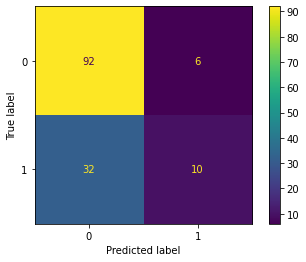

Precision tests: 0.625
Recall tests: 0.23809523809523808


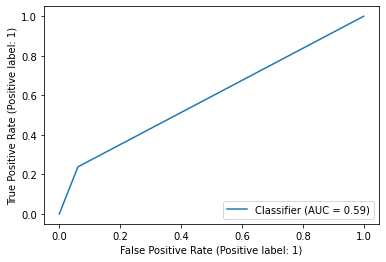

In [ ]:
gcv = GridSearchCV(estimator = lin, param_grid={'lin__lambd': [0, 0.00001, 0.001, 0.1], 'lin__nepoch': [1, 5, 10, 20], 'lin__batch_size': [1, 5, 10], 'lin__lr': [0.1, 0.01, 0.001]})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")
x_test_predict = gcv.best_estimator_.predict(x_test)
Print_scores(test_labels, x_test_predict)

{'lin__nepoch': 20, 'lin__lr': 0.1, 'lin__lambd': 0, 'lin__batch_size': 10}
Accuracy train: 0.725
Accuracy tests: 0.7214285714285714


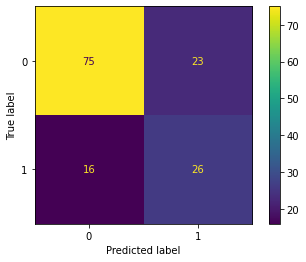

Precision tests: 0.5306122448979592
Recall tests: 0.6190476190476191


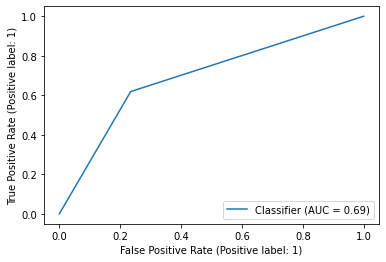

In [ ]:
rcv = RandomizedSearchCV(estimator = lin, param_distributions={'lin__lambd': [0, 0.00001, 0.001, 0.1], 'lin__nepoch': [1, 5, 10, 20], 'lin__batch_size': [1, 5, 10], 'lin__lr': [0.1, 0.01, 0.001]})
rcv.fit(x_train, train_labels)
print(rcv.best_params_)
print(f"Accuracy train: {rcv.best_score_}")
x_test_predict = rcv.best_estimator_.predict(x_test)
Print_scores(test_labels, x_test_predict)

In [ ]:
lin = Pipeline(steps = [('normalizer', Normalizer()),('lin', SGDClassifier(loss = 'hinge'))])
print(lin.get_params())

{'memory': None, 'steps': [('normalizer', Normalizer()), ('lin', SGDClassifier())], 'verbose': False, 'normalizer': Normalizer(), 'lin': SGDClassifier(), 'normalizer__copy': True, 'normalizer__norm': 'l2', 'lin__alpha': 0.0001, 'lin__average': False, 'lin__class_weight': None, 'lin__early_stopping': False, 'lin__epsilon': 0.1, 'lin__eta0': 0.0, 'lin__fit_intercept': True, 'lin__l1_ratio': 0.15, 'lin__learning_rate': 'optimal', 'lin__loss': 'hinge', 'lin__max_iter': 1000, 'lin__n_iter_no_change': 5, 'lin__n_jobs': None, 'lin__penalty': 'l2', 'lin__power_t': 0.5, 'lin__random_state': None, 'lin__shuffle': True, 'lin__tol': 0.001, 'lin__validation_fraction': 0.1, 'lin__verbose': 0, 'lin__warm_start': False}


{'lin__alpha': 0.001, 'lin__max_iter': 100}
Accuracy train: 0.7160714285714286
Accuracy tests: 0.7


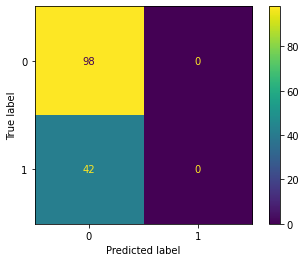

Precision tests: 0.0
Recall tests: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


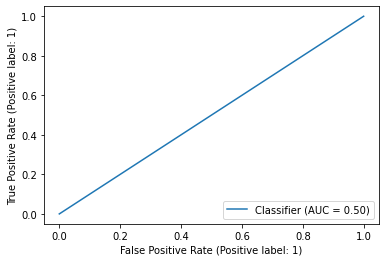

In [ ]:
gcv = GridSearchCV(estimator = lin, param_grid={'lin__max_iter': [100, 1000, 1500], 'lin__alpha': [0.1, 0.001, 0.0001]})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")
x_test_predict = gcv.best_estimator_.predict(x_test)
Print_scores(test_labels, x_test_predict)